# TRABAJO DE RECONOCIMIENTO DE VOZ

## Preparación del entorno

In [ ]:
!pip install matplotlib
# Para el reconocimiento de audio de Google
!pip install SpeechRecognition pyaudio
# Para el procesamiento de audio
!pip install librosa numpy
# Para crear un modelo de NN para Reconocimiento de voz
!pip install torch transformers

^C


Paquetes necesario para el correcto funcionamiento del sistema

In [12]:
import speech_recognition as sr
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import soundfile as sf
import torch.nn as nn
import os

## Reconocimiento de Voz usando Google

In [ ]:


def reconocer_voz():
    recognizer = sr.Recognizer()
    
    # Abrir el micrófono y empezar a escuchar
    with sr.Microphone() as source:
        print("Por favor, habla ahora...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

    try:
        texto = recognizer.recognize_google(audio, language="es-ES")
        print("Has dicho: " + texto)
    except sr.UnknownValueError:
        print("No se pudo entender el audio")
    except sr.RequestError:
        print("No se pudo acceder al servicio de reconocimiento")

reconocer_voz()

Por favor, habla ahora...
Has dicho: probar hasta cuánto eres capaz de detectar frases


Como máximo el codigo anterior es capaz de detectar 7 segundos de audio cosa que no nos viene bien, lo que vendría bien a este proyecto seria:
* Capaz de detectar palabras clave para la ayuda de personas (por ejemplo: ayuda, aqui, alguien, etc).
* Capaz de adquirir un trozo de audio y computarlo, asi consecutivamente hasta encontrar una palabra clave.
* Que pueda escuchar palabras a pesar de un gran ruido de fondo.

## Reconocimiento de voz usando una red preentrenada

### Creación de un archivo de audio si no tenemos ya uno

In [10]:
!pip install sounddevice scipy

In [15]:
import sounddevice as sd
from scipy.io.wavfile import write

# Parámetros de grabación
duration = 7  # Duración de la grabación en segundos
sample_rate = 44100  # Tasa de muestreo en Hz

print("Grabando...")
# Graba el audio
audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='int16')
sd.wait()  # Espera a que termine la grabación
print("Grabación terminada.")

# Guarda el archivo en formato WAV
if not os.path.exists("audio"):
    os.mkdir("audio")
filename = os.path.join("audio","grabacion.wav")
write(filename, sample_rate, audio_data)
print(f"Archivo guardado como {filename}")

Grabando...
Grabación terminada.
Archivo guardado como audio\grabacion.wav


### Características del audio

En la siguiente podemos ver un histograma creado a partir de archivo de audio

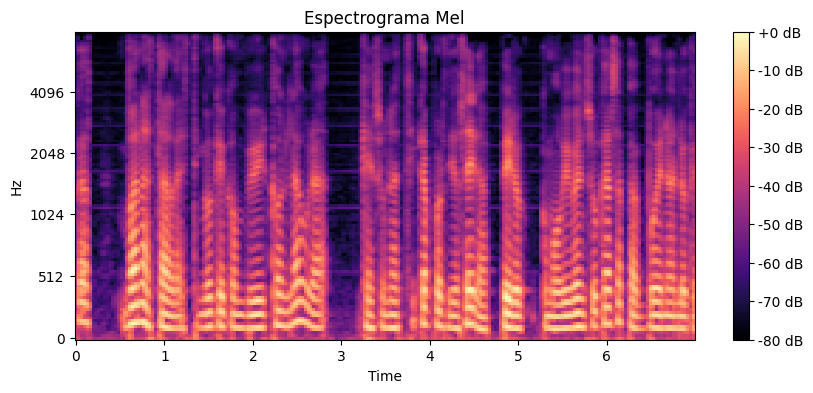

In [ ]:
def transformar_en_espectrograma(ruta_audio):
    audio, sr = librosa.load(ruta_audio, sr=16000)
    # Crear un espectrograma Mel
    espectrograma = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_espectrograma = librosa.power_to_db(espectrograma, ref=np.max)
    return log_espectrograma

# Visualizar el espectrograma
filename = os.path.join("audio","grabacion.wav")
espectrograma = transformar_en_espectrograma(filename)
plt.figure(figsize=(10, 4))
librosa.display.specshow(espectrograma, sr=16000, x_axis='Tiempo', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma Mel')
plt.show()

In [23]:
# Verificar si CUDA está disponible
if torch.cuda.is_available():
    print("CUDA está disponible. PyTorch puede usar la GPU.")
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA no está disponible. PyTorch usará la CPU.")

CUDA no está disponible. PyTorch usará la CPU.


In [22]:
modelo = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-spanish")
procesador = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-spanish")

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo = modelo.to(device)

c:\Users\User\Desktop\TFM\test reconocimiento de audio\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--jonatasgrosman--wav2vec2-large-xlsr-53-spanish. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
     ----------------- ---------------------- 2.4/5.3 MB 12.3 MB/s eta 0:00:01
     ----------------------------------- ---- 4.7/5.3 MB 11.9 MB/s eta 0:00:01
     ---------------------------------------- 5.3/5.3 MB 11.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ----------------------- ---------------- 2.4/4.0 MB 12.3 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 11.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 4.6 MB/s eta 0:09:51
     ---------------------------------------- 0.0/2.7 GB 7.7 MB/s eta 0:05:49
     ---------------------------------------- 0.0/2.7 GB 9.3 MB/s eta 0:04:51
     -----------------------

  You can safely remove it manually.


In [ ]:
def transcribir_audio(ruta_audio):
    # Leer el audio a 16 kHz
    audio, _ = librosa.load(ruta_audio, sr=16000)
    
    # Preprocesar el audio para el modelo
    entrada = procesador(audio, sampling_rate=16000, return_tensors="pt", padding=True)

    # Mover los datos a la GPU si está disponible
    entrada = entrada.to(device)

    # Obtener predicciones del modelo
    with torch.no_grad():
        logits = modelo(entrada.input_values).logits

    # Decodificar la transcripción
    ids_predichos = torch.argmax(logits, dim=-1)
    transcripcion = procesador.batch_decode(ids_predichos)[0]
    return transcripcion

# Ejecutar la transcripción
print("Transcripción:", transcribir_audio(filename))

Transcripción: vanas tardes tengo que convivir con laura que es una chica por dios era pero como vive en su casa bueno enlo


## Creación de modelo propio a partir de otros

In [27]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(SpeechRecognitionModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.lstm = nn.LSTM(32, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze(2)  # Ajuste de dimensiones
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [ ]:
modelo = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-spanish")
procesador = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-spanish")

In [ ]:
import torch.optim as optim

def entrenamiento(model, loader, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CTCLoss()  # CTC para modelos de secuencia
    for epoch in range(epochs):
        for batch in loader:
            inputs, targets, input_lengths, target_lengths = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")